## Import libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import fpfs
import galsim
import math 
import numpy as np
import matplotlib.pylab as plt
import scipy 

## Build Gradient Images

In [2]:
def makeGradientTopBottom(gradient):
    newrows = [] 
    for x in range(18): 
        value = x*gradient 
        #make the entire row a specific value 
        array = np.ones(18)*value 
        if x == 0: 
            gradientarray = array
        else: 
            newrows.append(array)

    for array in newrows: 
        gradientarray = np.vstack([gradientarray, array])
    
    return gradientarray

def makeGradient45(gradient): 
    # want to build such that along the diagonal you get a 1 bin change 
    newrows = [] 
    basevalues = []
    
    for i in range(30):
        if i == 0: 
            basevalues.extend([i*gradient])
        else: 
            basevalues.extend([i*gradient, i*gradient])
    
    for x in range(19):
        newrow = [basevalues[x-1:x+17]]
        start = (2*x) 
        end = 2*x+18
        if x == 0: 
            continue 
        elif x == 1: 
            gradientarray = newrow
        else: 
            newrows.append(newrow) 

    for array in newrows: 
        gradientarray = np.vstack([gradientarray, array])
    
    return gradientarray


In [3]:
def plotThreeGalaxies(image1, image2, image3, name1, name2, name3): 
    #create a plot 
    f, axs = plt.subplots(1, 3, figsize=(14,6))
    im0 = axs[0].imshow(image1, origin='lower', interpolation='None')
    axs[0].set_title(f'{name1}', fontsize=10)
    im1 = axs[1].imshow(image2, origin='lower', interpolation='None')    
    axs[1].set_title(f'{name2}', fontsize=10)
    im2 = axs[2].imshow(image3, origin='lower', interpolation='None')   
    axs[2].set_title(f'{name3}', fontsize=10)
    f.suptitle("Difference image of galaxy with gradient")
    f.colorbar(im0)
    f.colorbar(im1)
    f.colorbar(im2)

def combineGradientGalaxy(gradientimage, galaxyimage, plot):
    # I want to combine the array of the two images together 
    gradientgalaxy = gradientimage+galaxyimage.array
    #print(galaxyimage.array)
    if plot: 
        plotThreeGalaxies(gradientgalaxy, galaxyimage.array, gradientgalaxy-galaxyimage.array, "gradient galaxy", "galaxy", "gradient galaxy - galaxy") 
    # convert the array into an object 
    
    gradientgalaxyimage = galsim.Image(gradientgalaxy, copy=True)
    
    #convert the fits file to an object 
    gradientgalaxyobject = galsim.InterpolatedImage(image=gradientgalaxyimage, scale=0.2)

    return gradientgalaxyimage, gradientgalaxyobject

def combineGradientOnlyGalaxyProfile(gradientimage, galaxyimage, plot):
    # I want to cleverly design this such that I only add the gradient I have to the portion of the full array that is not-zero 
    unchangedgalaxyimage = np.copy(galaxyimage.array)
    
    a,b = np.nonzero(galaxyimage.array)
    # [a][b] are the indexes of nonzero elements of the galaxy 
    
    for x in range(len(a)):
        galaxyimage.array[a[x]][b[x]] = galaxyimage.array[a[x]][b[x]] + gradientimage[a[x]][b[x]] - a[0]

    if plot: 
        plotThreeGalaxies(galaxyimage.array, unchangedgalaxyimage, galaxyimage.array-unchangedgalaxyimage, "gradient galaxy", "galaxy", "gradient galaxy - galaxy") 

    gradientgalaxyimage = galsim.Image(galaxyimage, copy=True)
    
    #convert the fits file to an object 
    gradientgalaxyobject = galsim.InterpolatedImage(image=gradientgalaxyimage, scale=0.2)

    return gradientgalaxyimage, gradientgalaxyobject

def visualizeGradient(top, diag, plot, gradientamount, flux):
    order= 1
    b = 2*order - 1/3 + 4/(405*order) + 46/(25515*order**2) +131/ (1148175*order**3) - 2194697/(30690717750*order**4) 
    FWHM = 0.2
    re = -FWHM*b/(math.log(0.5))
    galaxyobject = galsim.Sersic(n=order, half_light_radius=re, flux=flux, trunc=2) 
    galaxyimage = galaxyobject.drawImage(scale=0.2, nx=18, ny=18, method='no_pixel')

    if top: 
        gradientimage = makeGradientTopBottom(gradientamount)
    if diag: 
        gradientimage = makeGradient45(gradientamount)

    gradientgalaxyimage, gradientgalaxyobject = combineGradientOnlyGalaxyProfile(gradientimage, galaxyimage, plot=plot)
    plt.show()

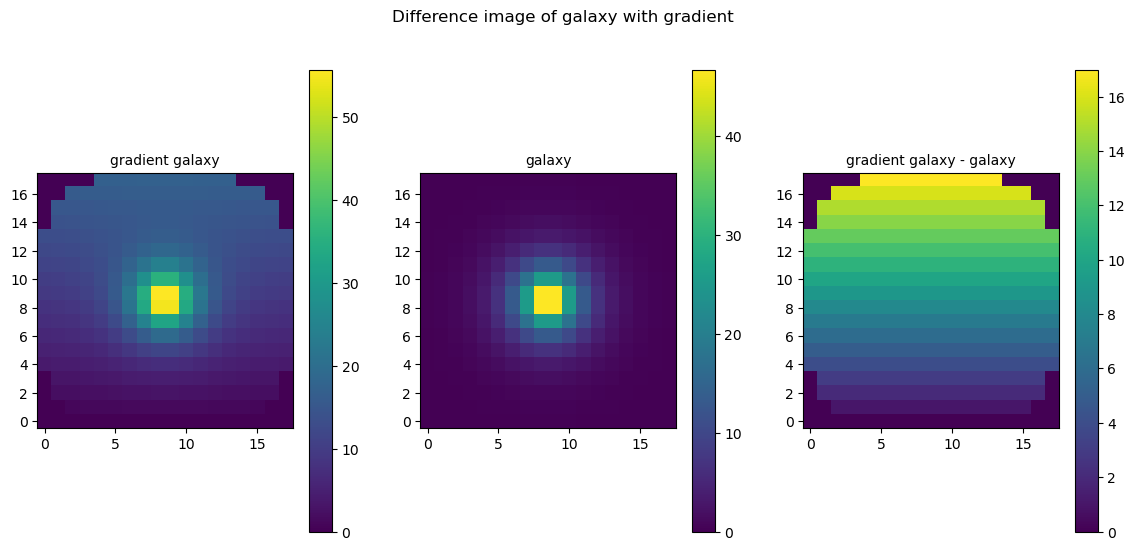

In [4]:
visualizeGradient(top=True, diag=False, plot=True, gradientamount=1, flux=1000)

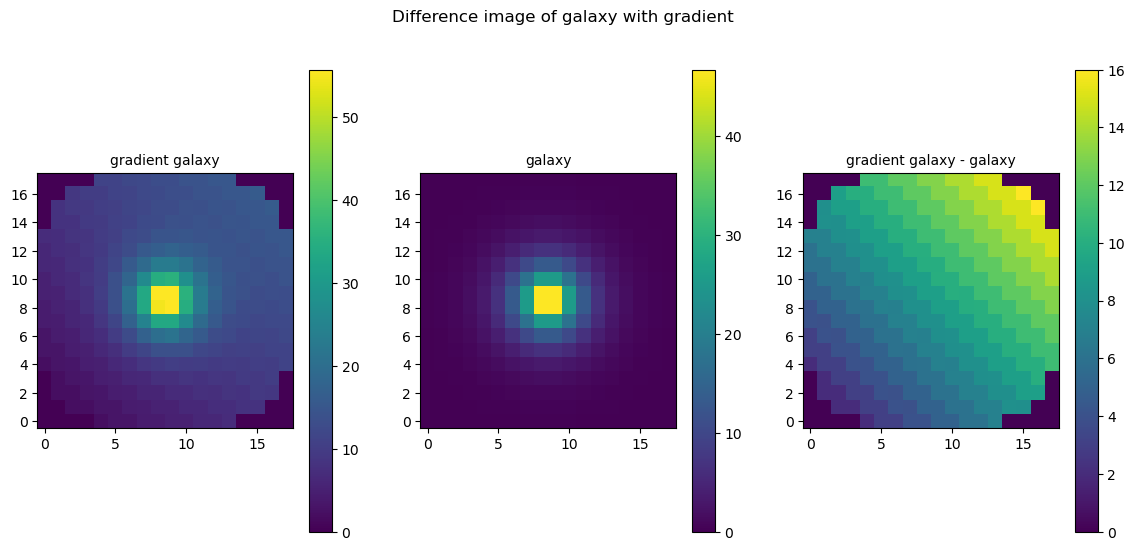

In [5]:
visualizeGradient(top=False, diag=True, plot=True, gradientamount=1, flux=1000)

## Measure the shear of gradient on a single galaxy

In [6]:
def measureShearWithGradient(top, diag, gradientamount, flux): 
    order= 1
    nn = 18
    scale = 0.2 
    b = 2*order - 1/3 + 4/(405*order) + 46/(25515*order**2) +131/ (1148175*order**3) - 2194697/(30690717750*order**4) 
    FWHM = 0.2
    re = -FWHM*b/(math.log(0.5))
    galaxyobject = galsim.Sersic(n=order, half_light_radius=re, flux=flux, trunc=2) 
    galaxyimage = galaxyobject.drawImage(scale=0.2, nx=18, ny=18, method='no_pixel')

    if top: 
        gradientimage = makeGradientTopBottom(gradientamount)
    if diag: 
        gradientimage = makeGradient45(gradientamount)
    
    gradientgalaxyimage, gradientgalaxyobject = combineGradientOnlyGalaxyProfile(gradientimage, galaxyimage, plot=True)

    # create a stamp 
    stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
    gal_array = stamp.sample_galaxy(gradientgalaxyobject)
    plt.close()

    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    coords = np.array([nn//2, nn//2])

    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.48)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)

    ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
    resp=np.average(ells['fpfs_R1E'])
    shear=np.average(ells['fpfs_e1'])/resp
    
    resp2=np.average(ells['fpfs_R2E'])
    shear2 = np.average(ells['fpfs_e2'])/resp2

    return shear, shear2 

In [7]:
measureShearWithGradient(top=True, diag=False, gradientamount=1, flux=1000)

(0.0012789843058741254, -4.53591470598489e-18)

In [8]:
measureShearWithGradient(top=False, diag=True, gradientamount=1, flux=1000)

(-8.184759026794463e-18, -2.133251767416951e-06)

## Look at the change in shear compared to no gradient

In [9]:
def plotChanges(flux, top, diag):
    g1s = [] 
    g2s = [] 
    gradientamounts = np.arange(0, 2, 0.1) 
    for x in gradientamounts:
        g1, g2 = measureShearWithGradient(top= top, diag= diag, gradientamount=x, flux=flux)
        g1s.append(g1)
        g2s.append(g2) 

    g1schange = g1s-g1s[0]
    g2schange = g2s-g2s[0]

    # g1 best fit 
    p = np.polyfit(gradientamounts, g1schange, 1) 
    slope, intercept = p
    y_pred = np.polyval(p, gradientamounts)

    # g2 best fit 
    q = np.polyfit(gradientamounts, g2schange, 1) 
    slope2, intercept2 = q
    y_pred2 = np.polyval(q, gradientamounts)

    f, axs = plt.subplots(1, 2, figsize=(14,6))
    f.suptitle(f'Changes to shear due to gradient applied, with base flux = {flux}', fontsize=16)

    axs[0].scatter(gradientamounts, g1schange, color='blue')
    axs[0].plot(gradientamounts, y_pred, label=f'best fit: g1 = {round(slope,5)}*gradient + {round(intercept,5)}', color='red') 
    
    axs[0].set_title("$\Delta g_{1}$ vs gradient change per pixel", fontsize=10)
    axs[0].set_xlabel("gradient change per pixel", fontsize=10)
    axs[0].set_ylabel("$\Delta g_{1}$", fontsize=10)
    axs[0].legend()
    axs[0].grid()
    
    axs[1].scatter(gradientamounts, g2schange, color='blue')
    axs[1].plot(gradientamounts, y_pred2, label=f'best fit: g2 = {round(slope2,7)}*gradient + {round(intercept2,9)}', color='red') 

    axs[1].set_title("$\Delta g_{2}$ vs gradient change per pixel", fontsize=10)
    axs[1].set_xlabel("gradient change per pixel", fontsize=10)
    axs[1].set_ylabel("$\Delta g_{2}$", fontsize=10)
    axs[1].legend()
    axs[1].grid()
    plt.show()

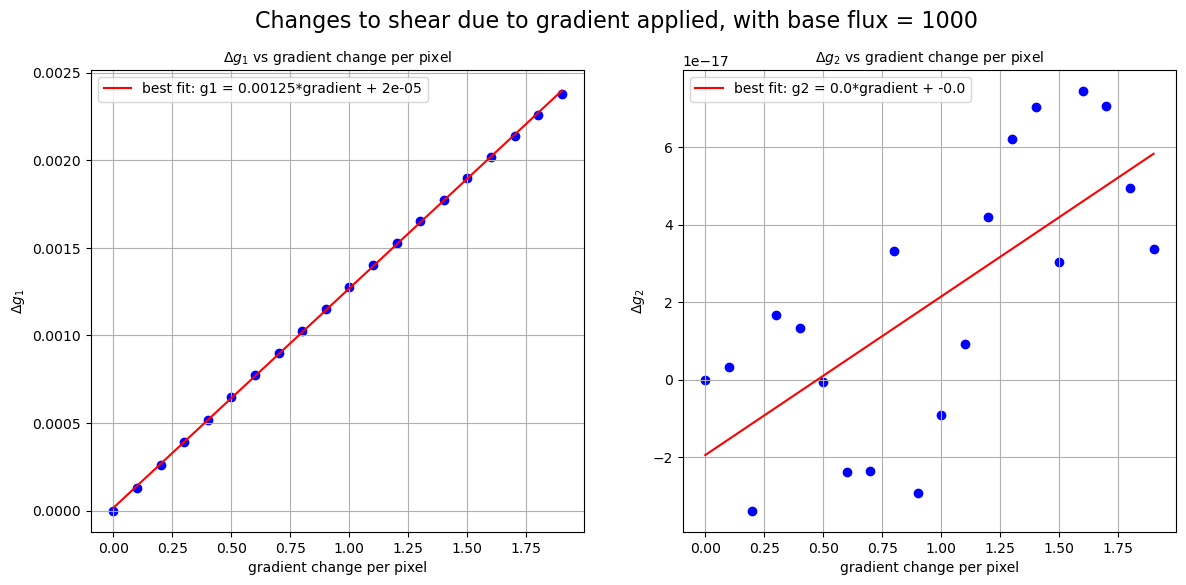

In [10]:
plotChanges(flux=1000, top=True, diag=False)

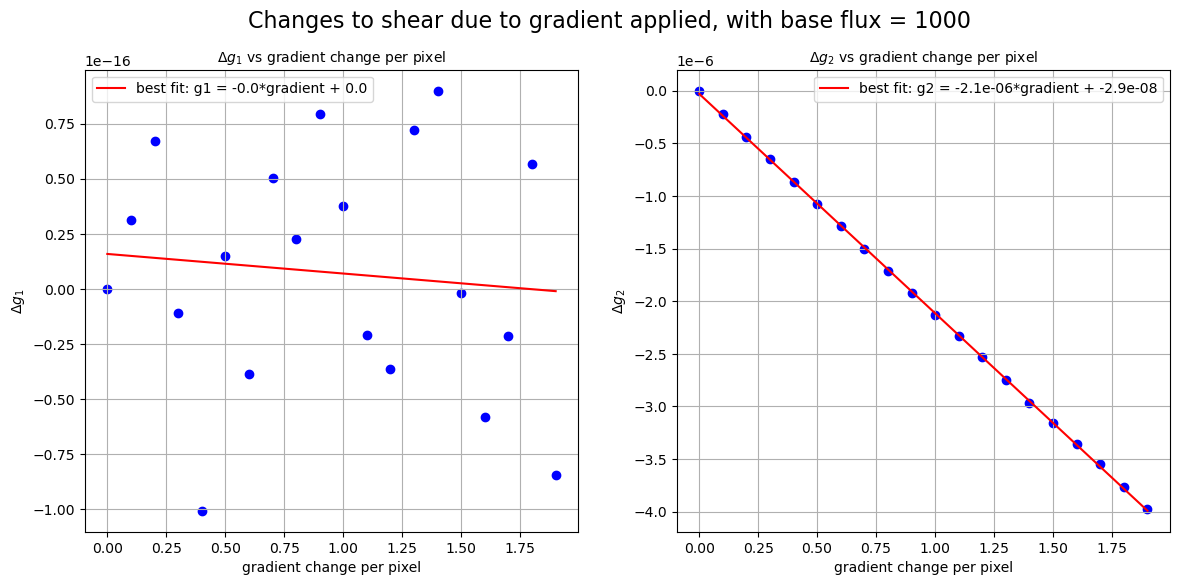

In [11]:
plotChanges(flux=1000, top=False, diag=True)

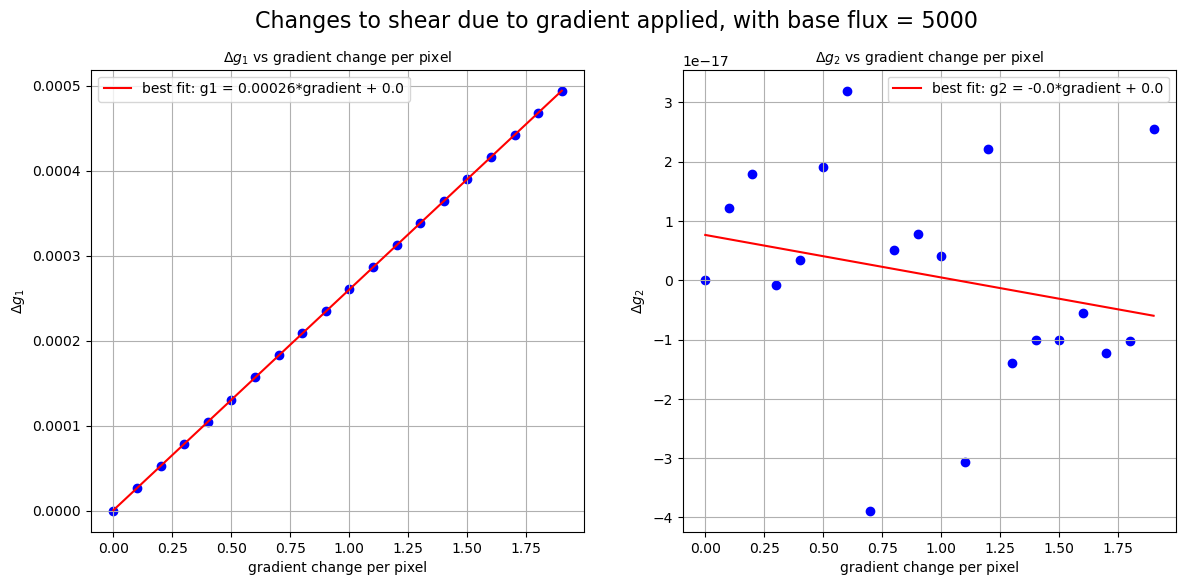

In [22]:
plotChanges(flux=5000, top=True, diag=False)

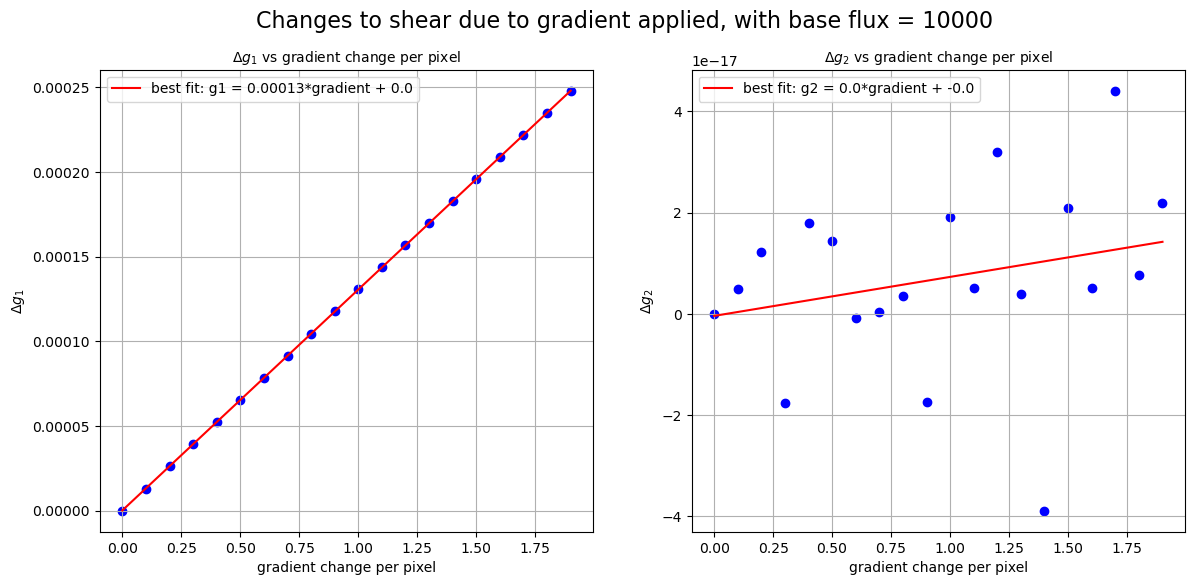

In [23]:
plotChanges(flux=10000, top=True, diag=False)

## Examine how flux affects change 

In [56]:
def getFluxSlope(flux, top, diag):
    g1s = [] 
    g2s = [] 
    gradientamounts = np.arange(0, 2, 0.1) 
    for x in gradientamounts:
        g1, g2 = measureShearWithGradient(top= top, diag= diag, gradientamount=x, flux=flux)
        g1s.append(g1)
        g2s.append(g2) 

    g1schange = g1s-g1s[0]
    g2schange = g2s-g2s[0]

    # g1 best fit 
    p = np.polyfit(gradientamounts, g1schange, 1) 
    slope, intercept = p

    # g2 best fit 
    q = np.polyfit(gradientamounts, g2schange, 1) 
    slope2, intercept2 = q

    return slope, slope2 

def plotManyFluxes(startflux, endflux, top, diag):
    fluxes = np.arange(startflux, endflux, 500) 
    g1slopes = []
    g2slopes = [] 
    for flux in fluxes: 
        slopeg1, slopeg2 = getFluxSlope(flux, top, diag)
        g1slopes.append(slopeg1)
        g2slopes.append(slopeg2)

    if top:
        gradienttype = 'top-bottom gradient'

    if diag: 
        gradienttype = 'diagonal gradient'
    
    f, axs = plt.subplots(1, 2, figsize=(14,6))
    f.suptitle(f"Slope of $\Delta$g due to applied {gradienttype} (0-2 counts per pixel) as a function of incident flux", fontsize=16)

    axs[0].scatter(fluxes, g1slopes, label='slope of best fit line g1')
    axs[0].set_xlabel('incident flux')
    axs[0].set_ylabel('slope of the best fit line of g1 change')
    axs[0].set_title('$\Delta g_{1}$ slope as a function of flux')
    axs[0].grid()
    axs[0].legend()

    axs[1].scatter(fluxes, g2slopes, label='slope of best fit line g2')
    axs[1].set_xlabel('incident flux')
    axs[1].set_ylabel('slope of the best fit line of g2 change')
    axs[1].set_title('$\Delta g_{2}$ slope as a function of flux')
    axs[1].grid()
    axs[1].legend()
    plt.show()


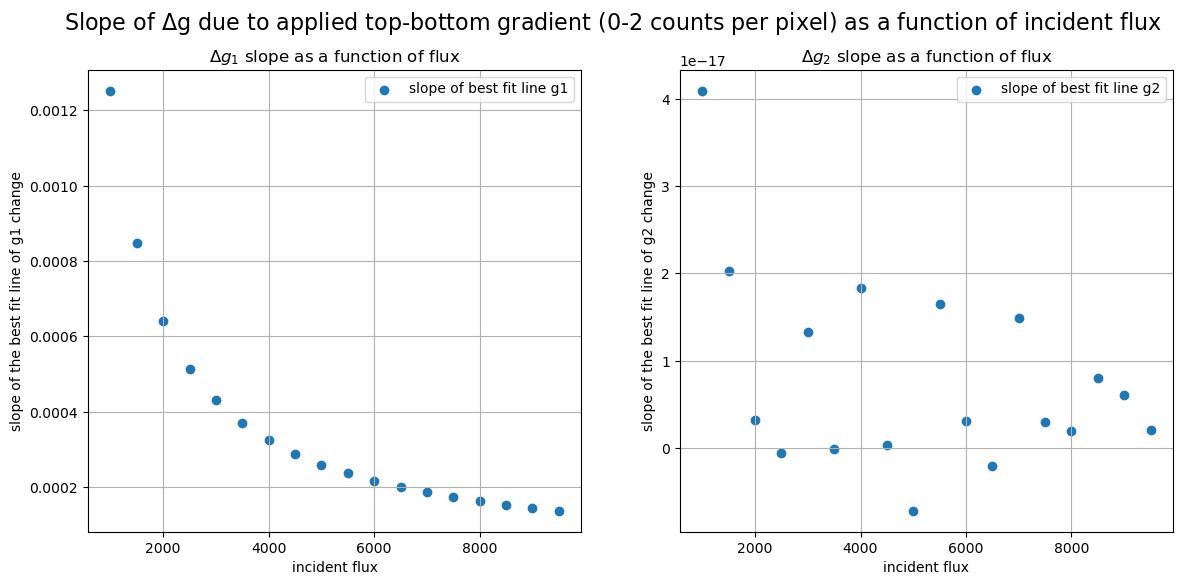

In [59]:
plotManyFluxes(1000, 10000, top=True, diag=False)

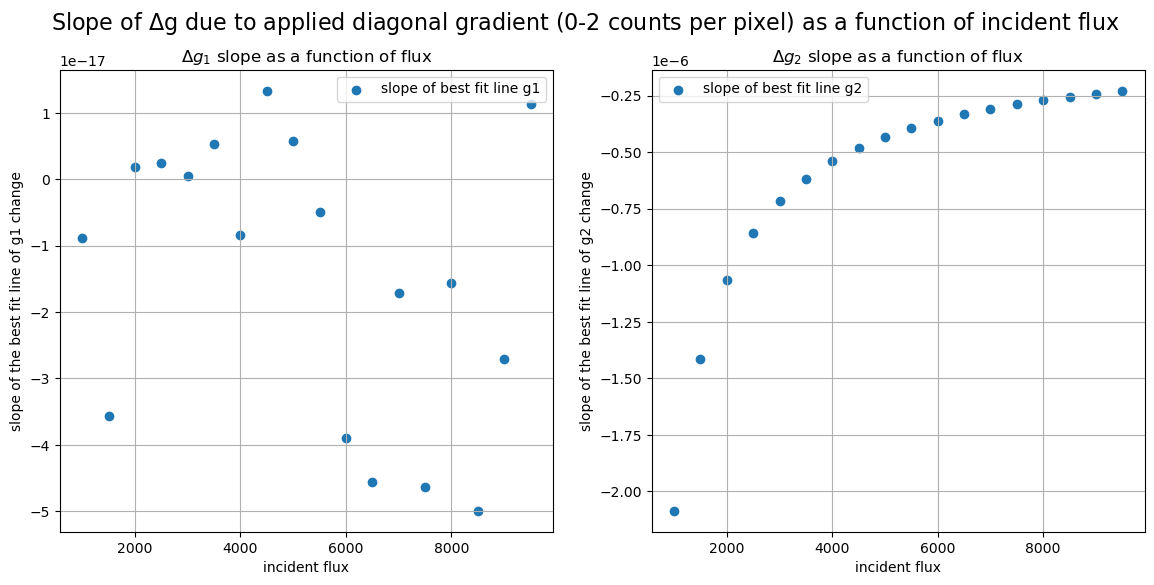

In [60]:
plotManyFluxes(1000, 10000, top=False, diag=True)

## Rotating the gradients to check for symmetric responses 

In [35]:
def visualizeGradientRotate(top, diag, plot, gradientamount, flux, rotate90, rotate180):
    order= 1
    b = 2*order - 1/3 + 4/(405*order) + 46/(25515*order**2) +131/ (1148175*order**3) - 2194697/(30690717750*order**4) 
    FWHM = 0.2
    re = -FWHM*b/(math.log(0.5))
    galaxyobject = galsim.Sersic(n=order, half_light_radius=re, flux=flux, trunc=2) 
    galaxyimage = galaxyobject.drawImage(scale=0.2, nx=18, ny=18, method='no_pixel')

    if top: 
        gradientimage = makeGradientTopBottom(gradientamount)
    if diag: 
        gradientimage = makeGradient45(gradientamount)

    if rotate90: 
        gradientimage = np.rot90(gradientimage)

    if rotate180: 
        gradientimage = np.rot90(gradientimage)
        gradientimage = np.rot90(gradientimage)

    gradientgalaxyimage, gradientgalaxyobject = combineGradientOnlyGalaxyProfile(gradientimage, galaxyimage, plot=plot)
    plt.show()

def measureShearWithGradientRotate(top, diag, gradientamount, flux, rotate90, rotate180): 
    order= 1
    nn = 18
    scale = 0.2 
    b = 2*order - 1/3 + 4/(405*order) + 46/(25515*order**2) +131/ (1148175*order**3) - 2194697/(30690717750*order**4) 
    FWHM = 0.2
    re = -FWHM*b/(math.log(0.5))
    galaxyobject = galsim.Sersic(n=order, half_light_radius=re, flux=flux, trunc=2) 
    galaxyimage = galaxyobject.drawImage(scale=0.2, nx=18, ny=18, method='no_pixel')

    if top: 
        gradientimage = makeGradientTopBottom(gradientamount)
    if diag: 
        gradientimage = makeGradient45(gradientamount)

    if rotate90: 
        gradientimage = np.rot90(gradientimage)

    if rotate180: 
        gradientimage = np.rot90(gradientimage)
        gradientimage = np.rot90(gradientimage)
        
    gradientgalaxyimage, gradientgalaxyobject = combineGradientOnlyGalaxyProfile(gradientimage, galaxyimage, plot=True)

    # create a stamp 
    stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
    gal_array = stamp.sample_galaxy(gradientgalaxyobject)
    plt.close()

    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    coords = np.array([nn//2, nn//2])

    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.2)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)

    ells=   fpfs.catalog.fpfs_m2e(mms, const=20)
    resp=np.average(ells['fpfs_R1E'])
    shear=np.average(ells['fpfs_e1'])/resp
    
    resp2=np.average(ells['fpfs_R2E'])
    shear2 = np.average(ells['fpfs_e2'])/resp2

    return shear, shear2 

In [66]:
## sigma = 0.2 

In [36]:
g1, g2 = measureShearWithGradientRotate(top=True, diag=False, gradientamount=1, flux=1000, rotate90=False, rotate180=False)
print("no rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=True, diag=False, gradientamount=1, flux=1000, rotate90=True, rotate180=False)
print("90 degree rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=True, diag=False, gradientamount=1, flux=1000, rotate90=False, rotate180=True)
print("180 degree rotation g1, g2", g1, g2) 

no rotation g1, g2 0.00029370186634623775 -1.8615202140382006e-17
90 degree rotation g1, g2 -0.00029370186634623715 -1.1906476693685891e-17
180 degree rotation g1, g2 -0.00029448251502325163 1.3104662054942983e-17


In [37]:
g1, g2 = measureShearWithGradientRotate(top=False, diag=True, gradientamount=1, flux=1000, rotate90=False, rotate180=False)
print("no rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=False, diag=True, gradientamount=1, flux=1000, rotate90=True, rotate180=False)
print("90 degree rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=False, diag=True, gradientamount=1, flux=1000, rotate90=False, rotate180=True)
print("180 degree rotation g1, g2", g1, g2) 

no rotation g1, g2 -1.5231615638429018e-17 5.821207344345535e-05
90 degree rotation g1, g2 -0.0002941109869139991 -5.828934280650768e-05
180 degree rotation g1, g2 1.0302606143411906e-17 5.8366790607931786e-05


In [38]:
# using sigma = 0.52 

In [24]:
g1, g2 = measureShearWithGradientRotate(top=True, diag=False, gradientamount=1, flux=1000, rotate90=False, rotate180=False)
print("no rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=True, diag=False, gradientamount=1, flux=1000, rotate90=True, rotate180=False)
print("90 degree rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=True, diag=False, gradientamount=1, flux=1000, rotate90=False, rotate180=True)
print("180 degree rotation g1, g2", g1, g2) 

no rotation g1, g2 0.0012789843058741254 -4.53591470598489e-18
90 degree rotation g1, g2 -0.0012789843058741508 2.974728331950416e-17
180 degree rotation g1, g2 -0.0012992161628057623 -1.6335805947172406e-17


In [25]:
g1, g2 = measureShearWithGradientRotate(top=False, diag=True, gradientamount=1, flux=1000, rotate90=False, rotate180=False)
print("no rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=False, diag=True, gradientamount=1, flux=1000, rotate90=True, rotate180=False)
print("90 degree rotation g1, g2", g1, g2) 
g1, g2 = measureShearWithGradientRotate(top=False, diag=True, gradientamount=1, flux=1000, rotate90=False, rotate180=True)
print("180 degree rotation g1, g2", g1, g2) 

no rotation g1, g2 -8.184759026794463e-18 -2.133251767416951e-06
90 degree rotation g1, g2 -0.0012884244660281217 2.149981630692177e-06
180 degree rotation g1, g2 4.483048811247109e-17 -2.1669759610873766e-06


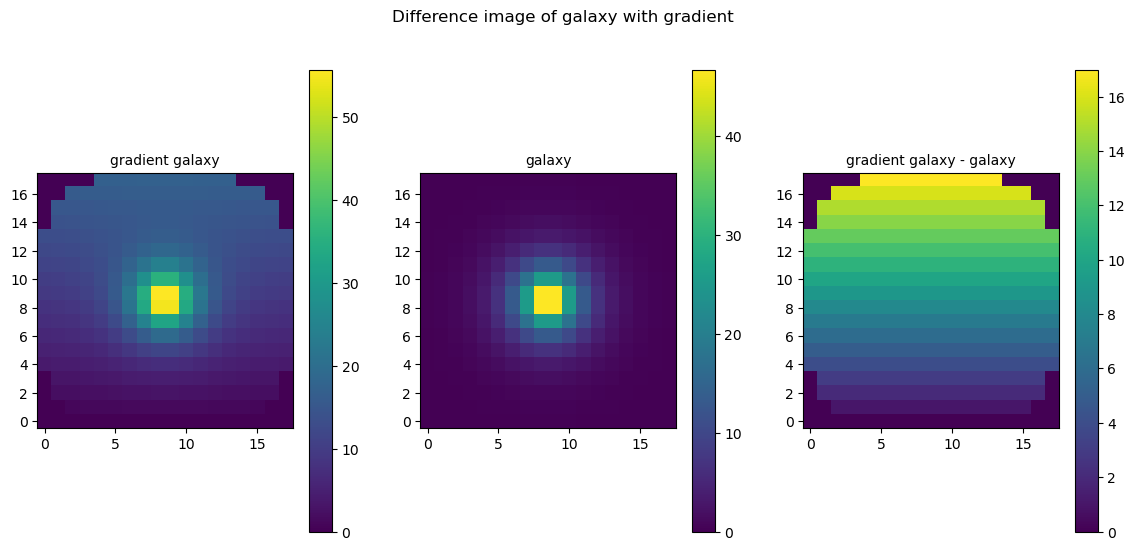

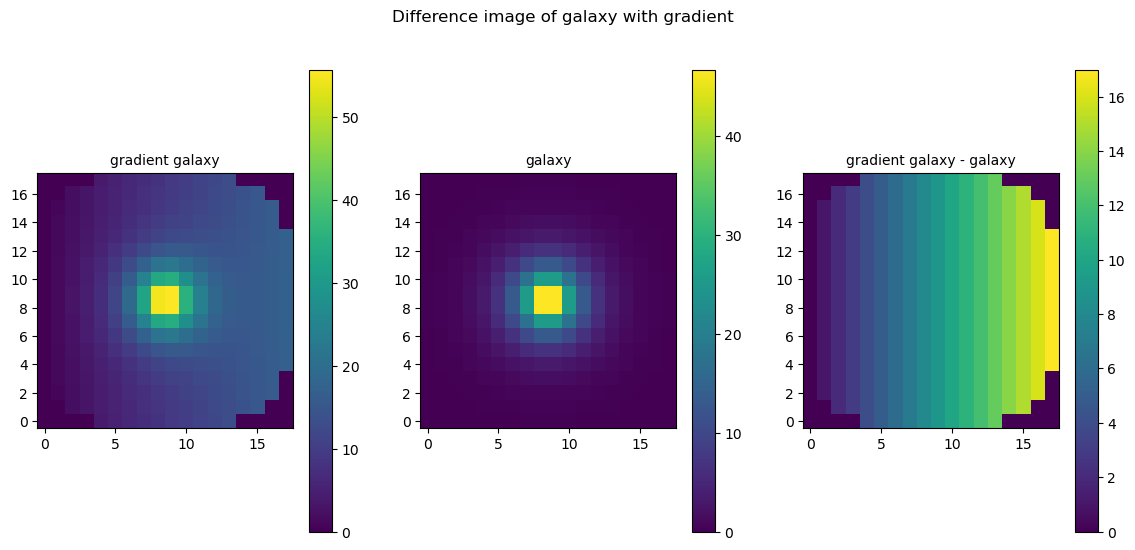

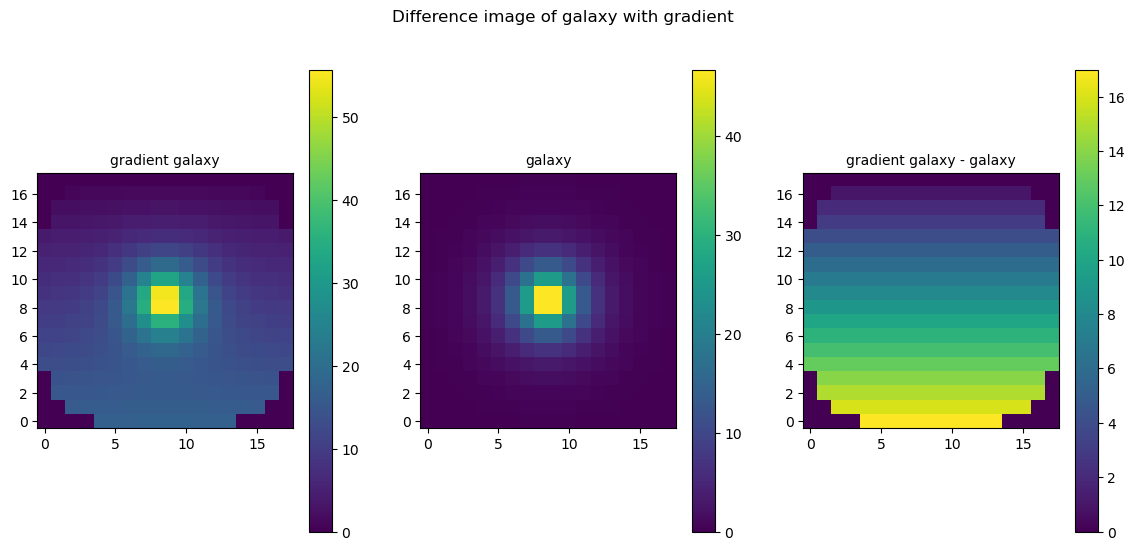

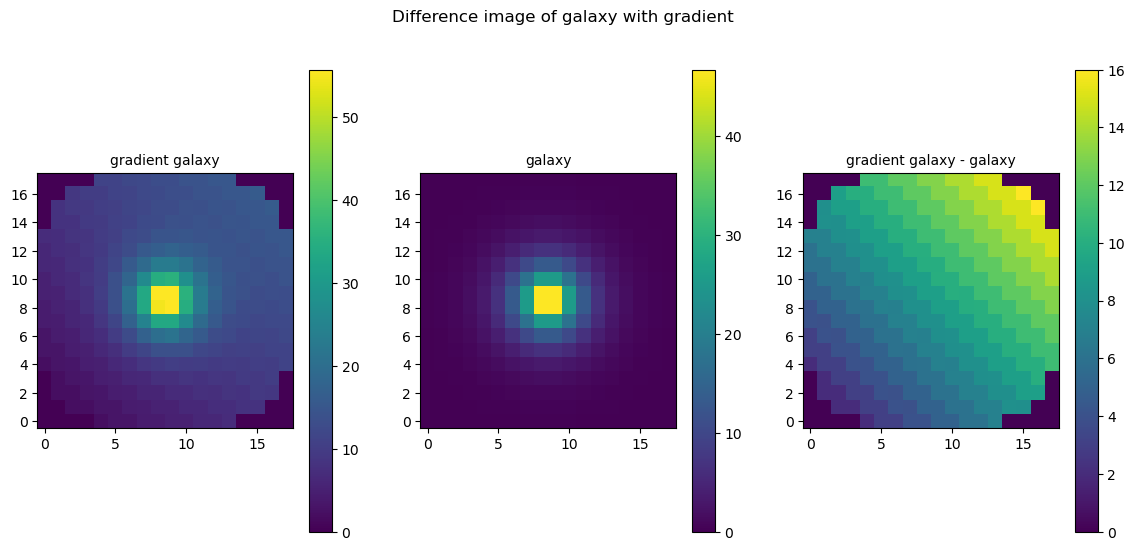

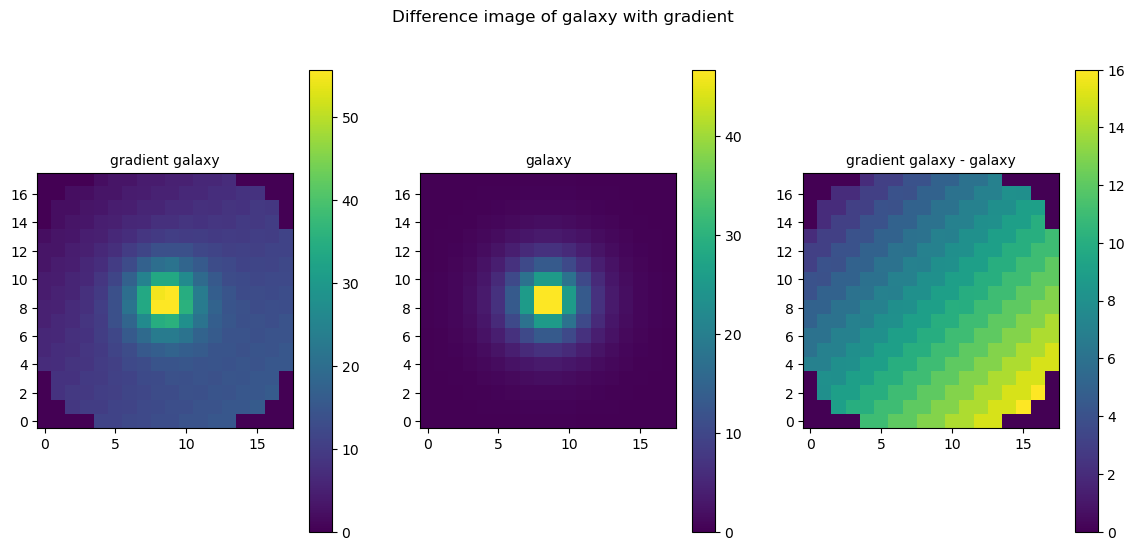

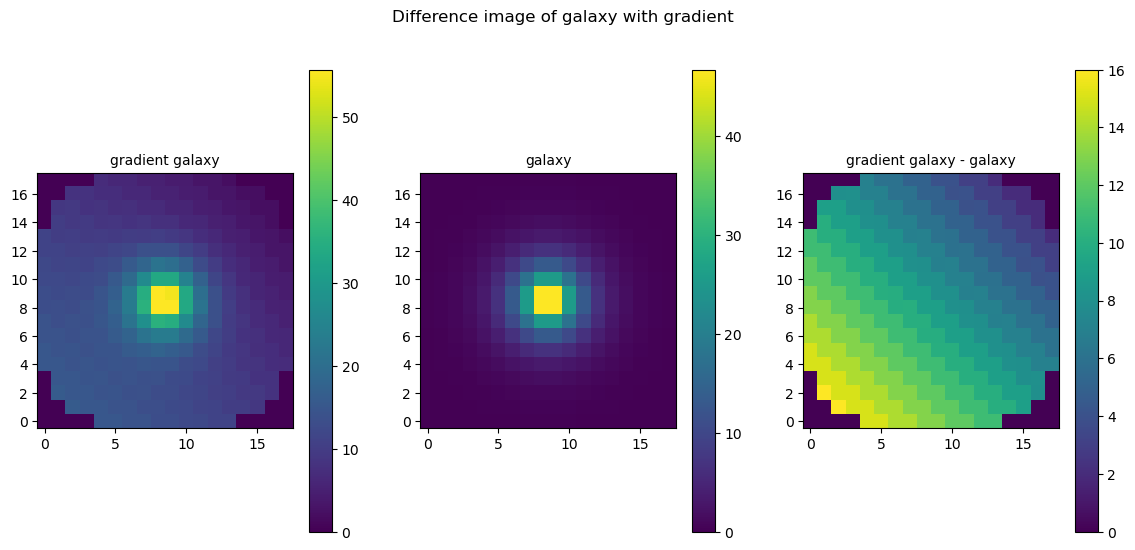

In [39]:
visualizeGradientRotate(top=True, diag=False, plot=True, gradientamount=1, flux=1000, rotate90=False, rotate180=False)
visualizeGradientRotate(top=True, diag=False, plot=True, gradientamount=1, flux=1000, rotate90=True, rotate180=False)
visualizeGradientRotate(top=True, diag=False, plot=True, gradientamount=1, flux=1000, rotate90=False, rotate180=True)
visualizeGradientRotate(top=False, diag=True, plot=True, gradientamount=1, flux=1000, rotate90=False, rotate180=False)
visualizeGradientRotate(top=False, diag=True, plot=True, gradientamount=1, flux=1000, rotate90=True, rotate180=False)
visualizeGradientRotate(top=False, diag=True, plot=True, gradientamount=1, flux=1000, rotate90=False, rotate180=True)